## **Loading the dataset**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style="whitegrid")
import json
from transformers import BartForConditionalGeneration, BartTokenizer
import torch
pd.set_option('display.max_colwidth', None)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

data = pd.read_csv("C:\\Users\\ELITEBOOK\\Downloads\\stock_news (1).csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ELITEBOOK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
warnings.filterwarnings("ignore")

## **Data Overview**

In [4]:
data.columns

Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label'], dtype='object')

In [5]:
data.duplicated().sum()

0

In [6]:
data.isna().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

In [7]:
data.dtypes

Date       object
News       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Label       int64
dtype: object

## **Exploratory Data Analysis**

In [8]:

data['Date'] = pd.to_datetime(data['Date'])

print(f"Data ranges from {data['Date'].min()} to {data['Date'].max()}")


Data ranges from 2019-01-02 00:00:00 to 2019-04-30 00:00:00


In [9]:
data.dtypes

Date      datetime64[ns]
News              object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Label              int64
dtype: object

In [10]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

***Univariate Analysis for News Sentiment Label (Categorical Variable)***

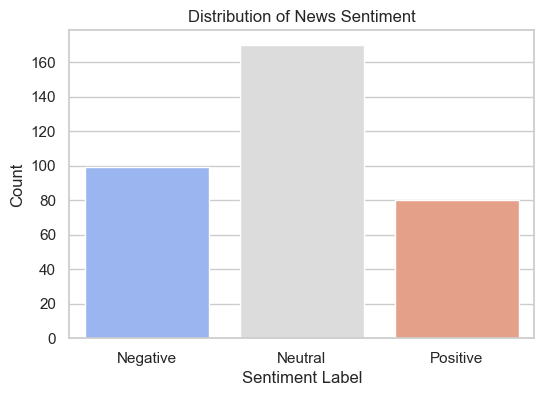

Label
 0    170
-1     99
 1     80
Name: count, dtype: int64


In [11]:

plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Label', palette='coolwarm')
plt.title('Distribution of News Sentiment')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

print(data['Label'].value_counts())


***Univariate Analysis for Numerical Variables (Open, High, Low, Close, Volume)***

***a) Stock Price (Open, High, Low, Close)***

             Open        High         Low       Close
count  349.000000  349.000000  349.000000  349.000000
mean    46.229233   46.700458   45.745394   44.926317
std      6.442817    6.507321    6.391976    6.398338
min     37.567501   37.817501   37.305000   36.254131
25%     41.740002   42.244999   41.482498   40.246914
50%     45.974998   46.025002   45.639999   44.596924
75%     50.707500   50.849998   49.777500   49.110790
max     66.817497   67.062500   65.862503   64.805229


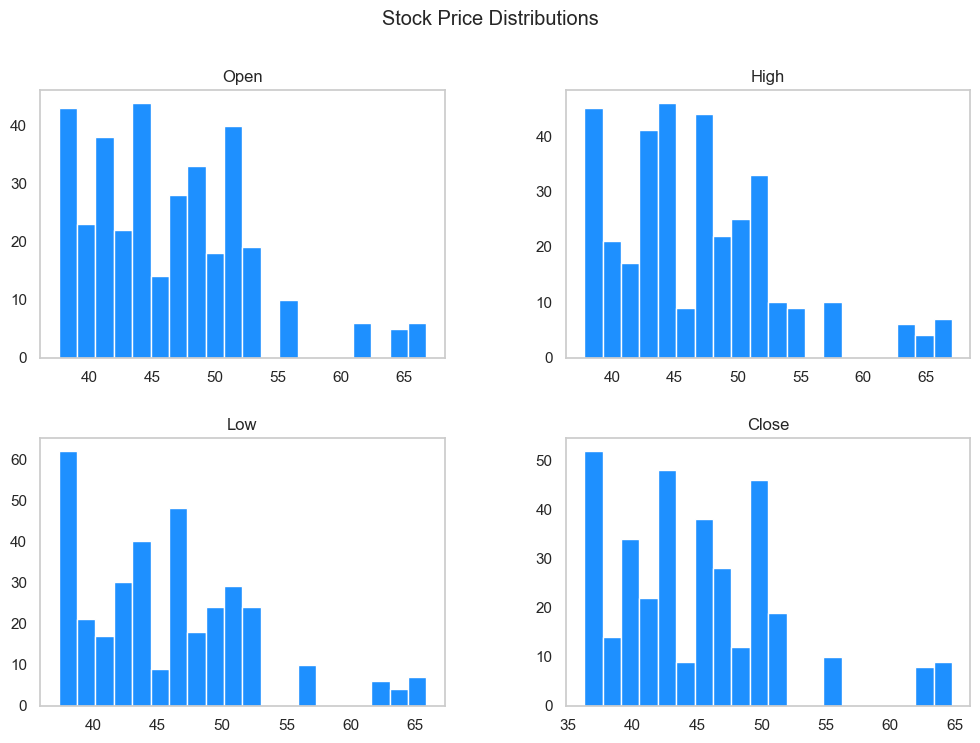

In [12]:

price_columns = ['Open', 'High', 'Low', 'Close']
print(data[price_columns].describe())

data[price_columns].hist(bins=20, figsize=(12, 8), color='dodgerblue', grid=False)
plt.suptitle('Stock Price Distributions')
plt.show()


***b) Trade Volume***

count    3.490000e+02
mean     1.289482e+08
std      4.317031e+07
min      4.544800e+07
25%      1.032720e+08
50%      1.156272e+08
75%      1.511252e+08
max      2.444392e+08
Name: Volume, dtype: float64


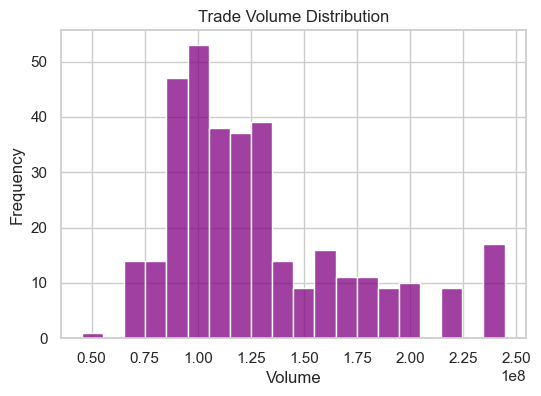

In [13]:

print(data['Volume'].describe())
plt.figure(figsize=(6, 4))
sns.histplot(data['Volume'], bins=20, color='purple')
plt.title('Trade Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()


***Univariate Analysis for News Content Length***

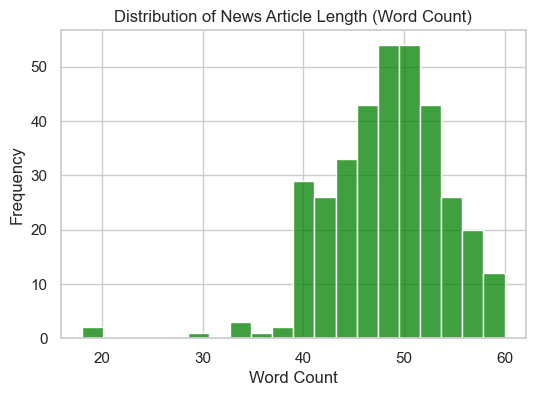

count    349.000000
mean      48.349570
std        5.717324
min       18.000000
25%       45.000000
50%       49.000000
75%       52.000000
max       60.000000
Name: News_length, dtype: float64


In [14]:

data['News_length'] = data['News'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6, 4))
sns.histplot(data['News_length'], bins=20, color='green')
plt.title('Distribution of News Article Length (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

print(data['News_length'].describe())


### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

***Correlation Between Numerical Variables***

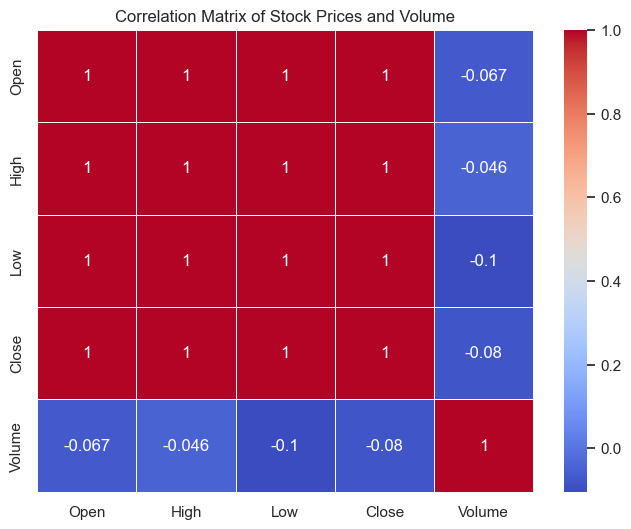

In [15]:

corr_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Prices and Volume')
plt.show()


**Sentiment Polarity vs Stock Prices**

***a) Box Plot of Sentiment vs Close Price***


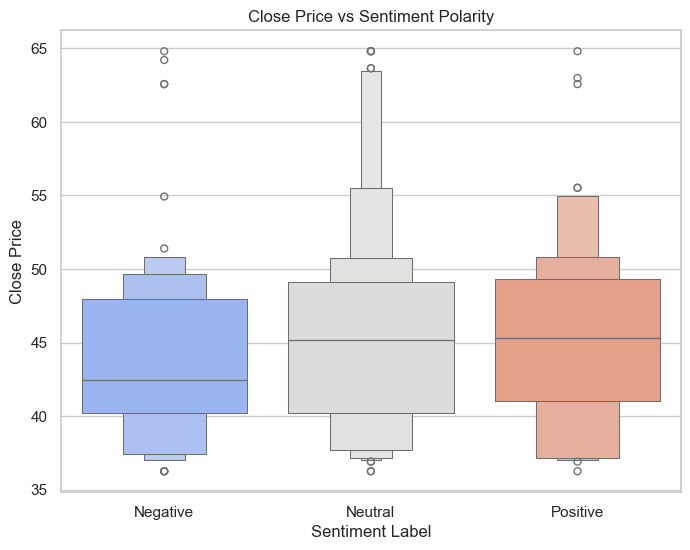

In [16]:

plt.figure(figsize=(8, 6))
sns.boxenplot(data=data, x='Label', y='Close', palette='coolwarm')
plt.title('Close Price vs Sentiment Polarity')
plt.xlabel('Sentiment Label')
plt.ylabel('Close Price')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()


***b) Box Plot of Sentiment vs Trade Volume***

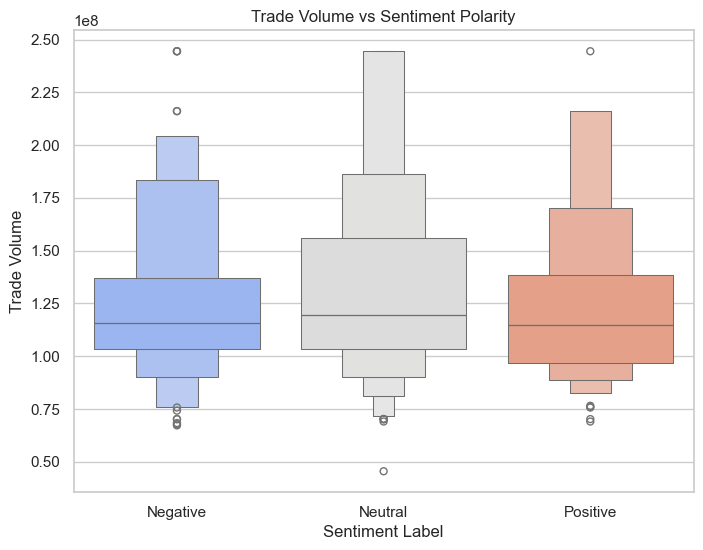

In [17]:

plt.figure(figsize=(8, 6))
sns.boxenplot(data=data, x='Label', y='Volume', palette='coolwarm')
plt.title('Trade Volume vs Sentiment Polarity')
plt.xlabel('Sentiment Label')
plt.ylabel('Trade Volume')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()


**Date vs Price (Time Series Analysis)**

***a) Date vs Close Price (Line Plot)***

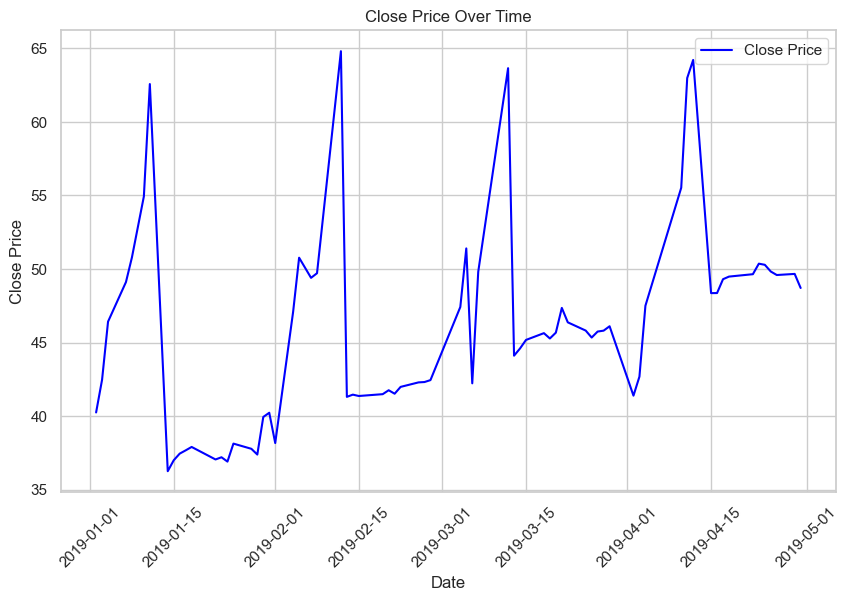

In [18]:

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'], color='blue', label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


***b) Date vs Volume (Line Plot)***

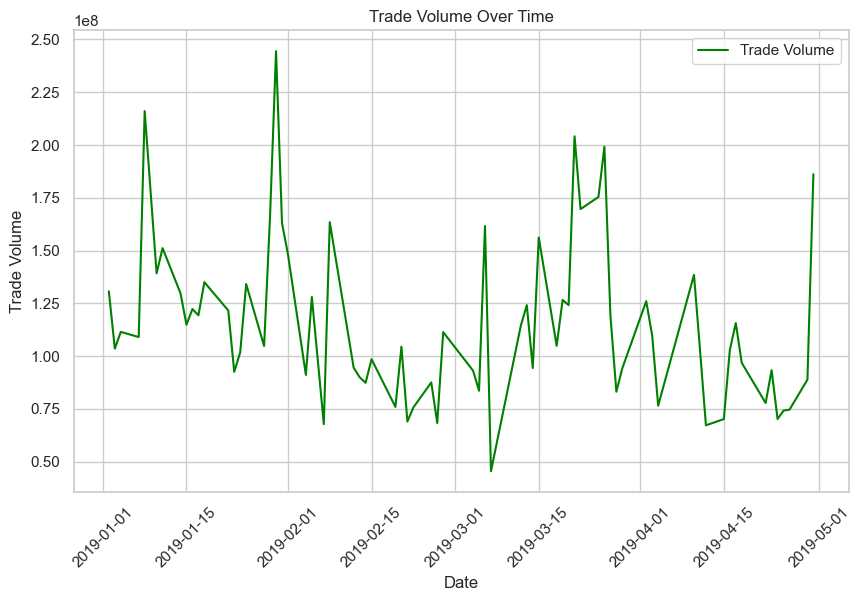

In [19]:

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Volume'], color='green', label='Trade Volume')
plt.title('Trade Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Trade Volume')
plt.xticks(rotation=45)
plt.legend()
plt.show()


***Overlaying Sentiment on Stock Price Time Series***

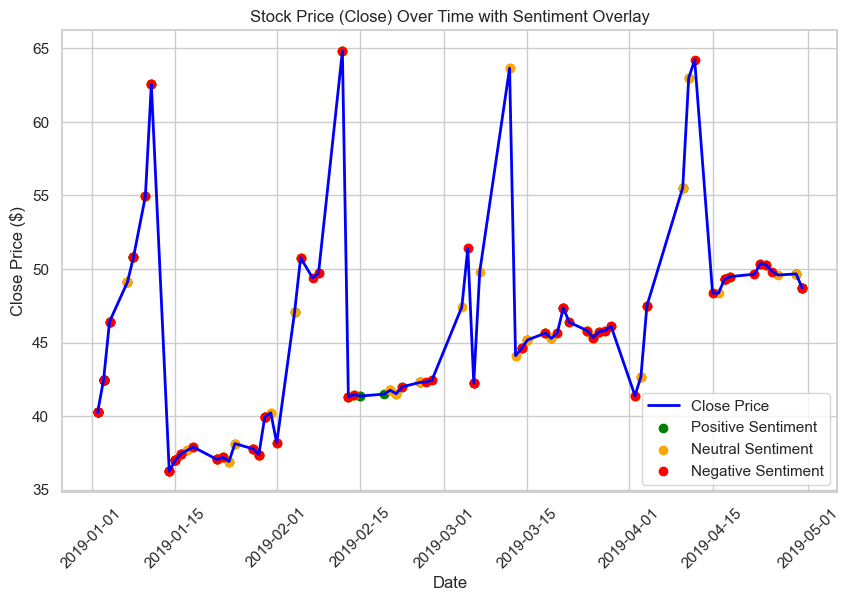

In [20]:

plt.figure(figsize=(10, 6))

sns.lineplot(data=data, x='Date', y='Close', label='Close Price', color='blue', linewidth=2)

plt.scatter(data[data['Label'] == 1]['Date'], data[data['Label'] == 1]['Close'], 
            color='green', label='Positive Sentiment', marker='o')

plt.scatter(data[data['Label'] == 0]['Date'], data[data['Label'] == 0]['Close'], 
            color='orange', label='Neutral Sentiment', marker='o')

plt.scatter(data[data['Label'] == -1]['Date'], data[data['Label'] == -1]['Close'], 
            color='red', label='Negative Sentiment', marker='o')

plt.title('Stock Price (Close) Over Time with Sentiment Overlay')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.xticks(rotation=45)
plt.legend()

plt.show()


**Sentiment Polarity vs Price Changes (Delta)**

***a) Calculate Price Change***

In [21]:

data['Price_Change'] = data['Close'].pct_change() * 100
data.dropna(inplace=True)  

print(data[['Price_Change', 'Label']].corr())


              Price_Change     Label
Price_Change      1.000000  0.062122
Label             0.062122  1.000000


***b) Visualizing Price Change vs Sentiment***

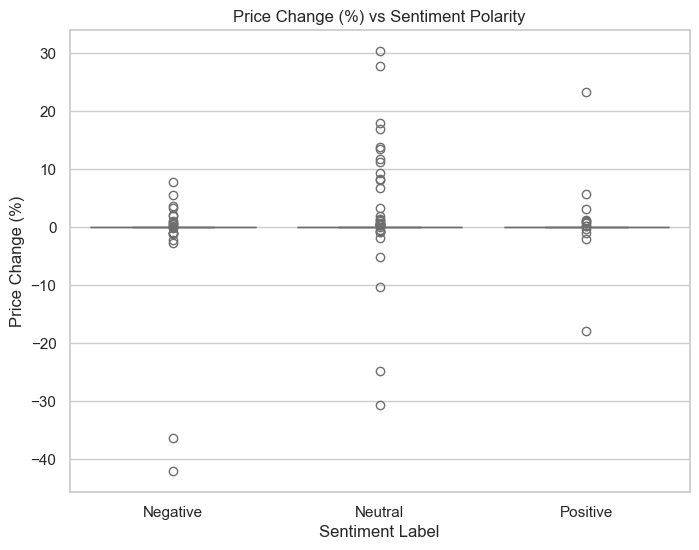

In [22]:

plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Label', y='Price_Change', palette='coolwarm')
plt.title('Price Change (%) vs Sentiment Polarity')
plt.xlabel('Sentiment Label')
plt.ylabel('Price Change (%)')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()


***Relationship Between High and Low Prices***

***a) Calculate Price Spread***

count    348.000000
mean       0.955617
std        0.485956
min        0.357498
25%        0.564998
50%        0.845001
75%        1.129997
max        2.822499
Name: Price_Spread, dtype: float64


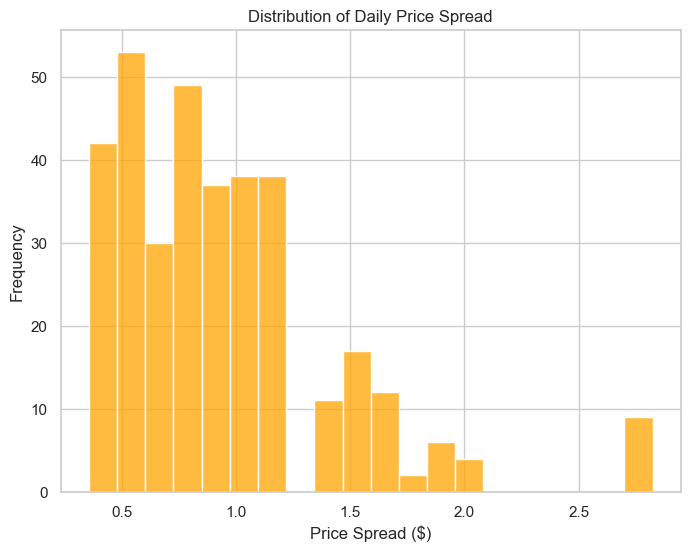

In [23]:

data['Price_Spread'] = data['High'] - data['Low']

print(data['Price_Spread'].describe())

plt.figure(figsize=(8, 6))
sns.histplot(data['Price_Spread'], bins=20, color='orange')
plt.title('Distribution of Daily Price Spread')
plt.xlabel('Price Spread ($)')
plt.ylabel('Frequency')
plt.show()


***b) Price Spread vs Sentiment***

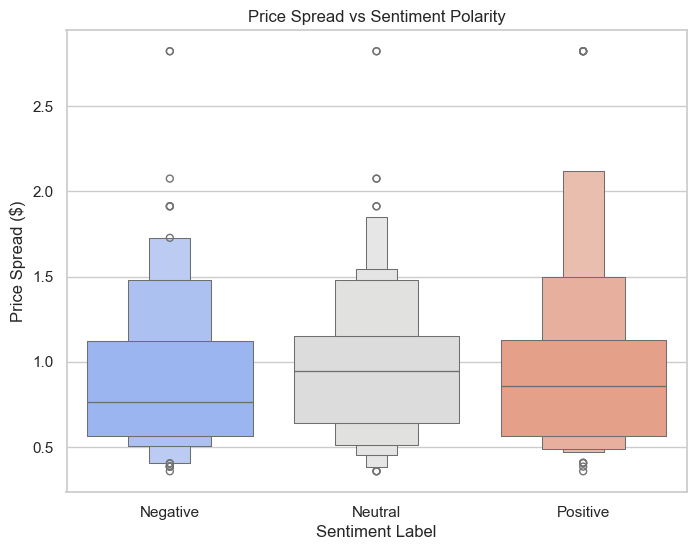

In [24]:

plt.figure(figsize=(8, 6))
sns.boxenplot(data=data, x='Label', y='Price_Spread', palette='coolwarm')
plt.title('Price Spread vs Sentiment Polarity')
plt.xlabel('Sentiment Label')
plt.ylabel('Price Spread ($)')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()


***7. Volume vs Stock Price (Scatter Plot)***

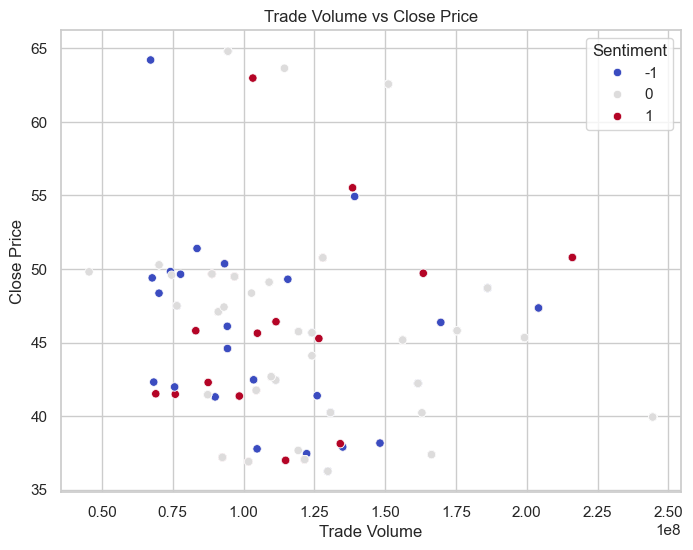

In [25]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Volume', y='Close', hue='Label', palette='coolwarm')
plt.title('Trade Volume vs Close Price')
plt.xlabel('Trade Volume')
plt.ylabel('Close Price')
plt.legend(title='Sentiment')
plt.show()


**How Sentiments Impact The Daily Returns**

In [26]:

data['Daily_Returns'] = data['Close'].pct_change() * 100  

data.dropna(inplace=True)



**Boxplot: Sentiment Impact on Daily Returns**

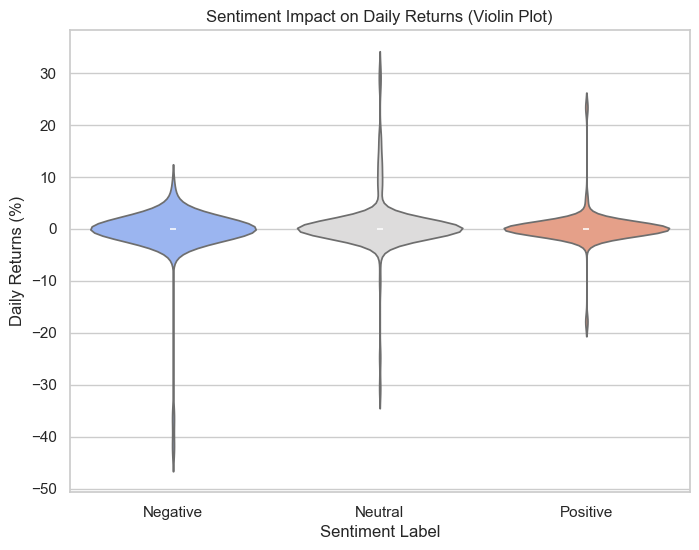

In [27]:

plt.figure(figsize=(8, 6))
sns.violinplot(data=data, x='Label', y='Daily_Returns', palette='coolwarm')

plt.title('Sentiment Impact on Daily Returns (Violin Plot)')
plt.xlabel('Sentiment Label')
plt.ylabel('Daily Returns (%)')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()


***Summary Statistics for Daily Returns by Sentiment***

In [28]:

summary_stats = data.groupby('Label')['Daily_Returns'].describe()
print(summary_stats)


       count      mean       std        min  25%  50%  75%        max
Label                                                                
-1      97.0 -0.612275  5.765525 -42.059539  0.0  0.0  0.0   7.798154
 0     170.0  0.669418  5.353967 -30.704185  0.0  0.0  0.0  30.359653
 1      80.0  0.195461  3.404070 -17.843038  0.0  0.0  0.0  23.386604


***Density Plot: Sentiment vs Daily Returns***

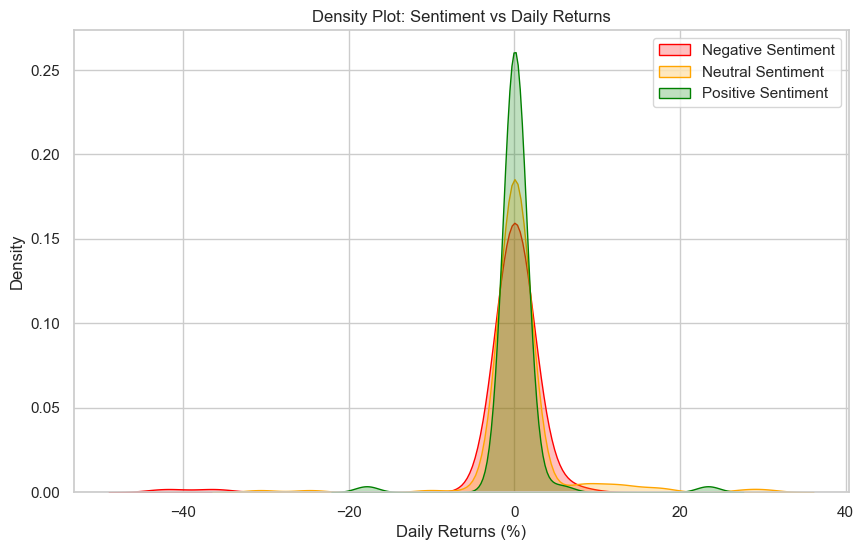

In [29]:

plt.figure(figsize=(10, 6))

sns.kdeplot(data=data[data['Label'] == -1]['Daily_Returns'], color='red', label='Negative Sentiment', shade=True)

sns.kdeplot(data=data[data['Label'] == 0]['Daily_Returns'], color='orange', label='Neutral Sentiment', shade=True)

sns.kdeplot(data=data[data['Label'] == 1]['Daily_Returns'], color='green', label='Positive Sentiment', shade=True)

plt.title('Density Plot: Sentiment vs Daily Returns')
plt.xlabel('Daily Returns (%)')
plt.ylabel('Density')
plt.legend()
plt.show()


***Correlation Between Sentiment and Daily Returns***

In [30]:

correlation = data[['Label', 'Daily_Returns']].corr().iloc[0, 1]
print(f"Correlation between Sentiment and Daily Returns: {correlation:.4f}")


Correlation between Sentiment and Daily Returns: 0.0621


## **Data Preprocessing**

In [31]:
X = data[['Open','High', 'Low', 'Volume', 'Label']]
y= data['Close']

***Data Standardization***

In [32]:
scaler = MinMaxScaler()
numeric_columns = ['Open', 'High', 'Low', 'Volume']
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

X.head()

,Open,High,Low,Volume,Label
2,0.14265,0.151393,0.146284,0.428282,-1
3,0.14265,0.151393,0.146284,0.428282,-1
4,0.14265,0.151393,0.146284,0.428282,-1
5,0.14265,0.151393,0.146284,0.428282,0
6,0.14265,0.151393,0.146284,0.428282,1


***Train and Test split,Validation and Balancing the data***

In [33]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (242, 5), Validation set: (52, 5), Test set: (53, 5)


***XGBOOST***

In [34]:

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_

y_val_pred_xgb = best_xgb_model.predict(X_val)
y_test_pred_xgb = best_xgb_model.predict(X_test)

rmse_val_xgb = mean_squared_error(y_val, y_val_pred_xgb, squared=False)
r2_val_xgb = r2_score(y_val, y_val_pred_xgb)

rmse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb, squared=False)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print(f'XGBoost Validation RMSE: {rmse_val_xgb:.2f}, R2: {r2_val_xgb:.2f}')
print(f'XGBoost Test RMSE: {rmse_test_xgb:.2f}, R2: {r2_test_xgb:.2f}')


XGBoost Validation RMSE: 0.04, R2: 1.00
XGBoost Test RMSE: 0.04, R2: 1.00


*The results indicate that the XGBoost model performed exceptionally well on both the validation and test datasets. With a Root Mean Squared Error (RMSE) of 0.04 for validation and 0.04 for test, the model's predictions are very close to the actual values, suggesting high accuracy. Furthermore, the R² score of 1.00 for both datasets indicates that the model explains all the variability in the target variable, meaning it perfectly fits the data. Overall, these metrics suggest that the model is highly effective for this prediction task.*

## **Word Embeddings**

***Word2Vec and GloVe Embeddings***

In [35]:


def preprocess(text):
    text = text.lower()
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

data['cleaned_news'] = data['News'].apply(preprocess)

X_train, X_test, y_train, y_test = train_test_split(data['cleaned_news'], data['Label'], test_size=0.2, random_state=42)

tokenized_train = [text.split() for text in X_train]

word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=5)
word2vec_model.save('word2vec.model')

def get_word2vec_embeddings(text):
    words = text.split()
    embedding = np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv], axis=0)
    return embedding

X_train_w2v = np.array([get_word2vec_embeddings(text) for text in X_train])
X_test_w2v = np.array([get_word2vec_embeddings(text) for text in X_test])

embedding_index = {}
glove_file = "C:\\Users\\ELITEBOOK\\Downloads\\glove.6B\\glove.6B.300d.txt"

with open(glove_file, 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

def get_glove_embeddings(text):
    words = text.split()
    embedding = np.mean([embedding_index[word] for word in words if word in embedding_index], axis=0)
    return embedding

X_train_glove = np.array([get_glove_embeddings(text) for text in X_train])
X_test_glove = np.array([get_glove_embeddings(text) for text in X_test])

rf_model_w2v = RandomForestClassifier()
rf_model_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = rf_model_w2v.predict(X_test_w2v)

print("Word2Vec Classification Report:")
print(classification_report(y_test, y_pred_w2v))

rf_model_glove = RandomForestClassifier()
rf_model_glove.fit(X_train_glove, y_train)
y_pred_glove = rf_model_glove.predict(X_test_glove)

print("GloVe Classification Report:")
print(classification_report(y_test, y_pred_glove))




Word2Vec Classification Report:
              precision    recall  f1-score   support

          -1       0.38      0.33      0.36        15
           0       0.55      0.86      0.67        36
           1       0.00      0.00      0.00        19

    accuracy                           0.51        70
   macro avg       0.31      0.40      0.34        70
weighted avg       0.37      0.51      0.42        70

GloVe Classification Report:
              precision    recall  f1-score   support

          -1       0.31      0.33      0.32        15
           0       0.54      0.78      0.64        36
           1       0.50      0.05      0.10        19

    accuracy                           0.49        70
   macro avg       0.45      0.39      0.35        70
weighted avg       0.48      0.49      0.42        70



**Confusion Matrix**

Word2Vec Classification Report:
              precision    recall  f1-score   support

          -1       0.45      0.33      0.38        15
           0       0.54      0.89      0.67        36
           1       0.00      0.00      0.00        19

    accuracy                           0.53        70
   macro avg       0.33      0.41      0.35        70
weighted avg       0.38      0.53      0.43        70



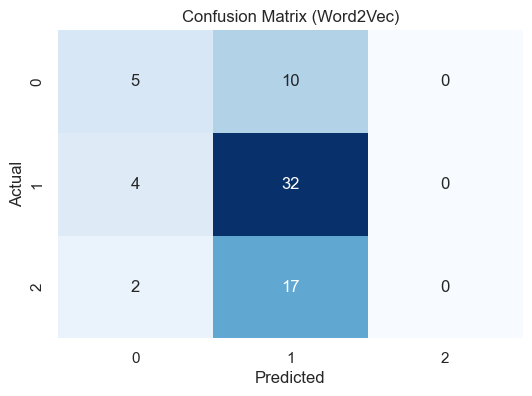

GloVe Classification Report:
              precision    recall  f1-score   support

          -1       0.43      0.40      0.41        15
           0       0.56      0.83      0.67        36
           1       0.00      0.00      0.00        19

    accuracy                           0.51        70
   macro avg       0.33      0.41      0.36        70
weighted avg       0.38      0.51      0.43        70



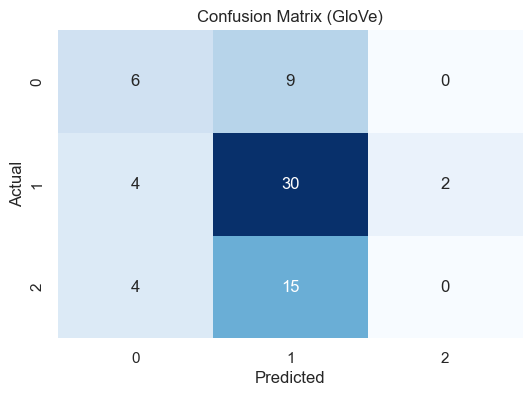

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

rf_model_w2v = RandomForestClassifier()
rf_model_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = rf_model_w2v.predict(X_test_w2v)

print("Word2Vec Classification Report:")
print(classification_report(y_test, y_pred_w2v))

conf_matrix_w2v = confusion_matrix(y_test, y_pred_w2v)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_w2v, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix (Word2Vec)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

rf_model_glove = RandomForestClassifier()
rf_model_glove.fit(X_train_glove, y_train)
y_pred_glove = rf_model_glove.predict(X_test_glove)

print("GloVe Classification Report:")
print(classification_report(y_test, y_pred_glove))

conf_matrix_glove = confusion_matrix(y_test, y_pred_glove)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_glove, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix (GloVe)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


***Sentence Tranformers and Hyperparameter Tuning***

In [37]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')

X_train_sent = model.encode(X_train.tolist())
X_test_sent = model.encode(X_test.tolist())

rf_model_sent = RandomForestClassifier()
rf_model_sent.fit(X_train_sent, y_train)
y_pred_sent = rf_model_sent.predict(X_test_sent)

print("Sentence Transformer Classification Report:")
print(classification_report(y_test, y_pred_sent))

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_w2v, y_train)
print(f"Best parameters for Word2Vec: {grid_search.best_params_}")

grid_search.fit(X_train_glove, y_train)
print(f"Best parameters for GloVe: {grid_search.best_params_}")

grid_search.fit(X_train_sent, y_train)
print(f"Best parameters for Sentence Transformer: {grid_search.best_params_}")



Sentence Transformer Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.33      0.40        15
           0       0.59      0.72      0.65        36
           1       0.62      0.53      0.57        19

    accuracy                           0.59        70
   macro avg       0.57      0.53      0.54        70
weighted avg       0.58      0.59      0.58        70

Best parameters for Word2Vec: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for GloVe: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best parameters for Sentence Transformer: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


***Model Comparison***

In [38]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{model_name} - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")

evaluate_model(y_test, y_pred_w2v, 'Word2Vec')
evaluate_model(y_test, y_pred_glove, 'GloVe')
evaluate_model(y_test, y_pred_sent, 'Sentence Transformer')

y_test_pred_final = grid_search.best_estimator_.predict(X_test_sent)
evaluate_model(y_test, y_test_pred_final, 'Final Model')


Word2Vec - Accuracy: 0.53, F1 Score: 0.43
GloVe - Accuracy: 0.51, F1 Score: 0.43
Sentence Transformer - Accuracy: 0.59, F1 Score: 0.58
Final Model - Accuracy: 0.53, F1 Score: 0.51


## **Sentiment Analysis**

## **Weekly News Summarization**

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

In [39]:


data = pd.read_csv("C:\\Users\\ELITEBOOK\\Downloads\\stock_news.csv")

In [40]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

In [41]:
data = data.groupby('Date')['News'].apply(lambda x: ' '.join(x)).reset_index()
pd.set_option('display.max_colwidth', None)
print(data['News'].head(1))

0     The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon  This news article reports that yields on long-da

In [42]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)
weekly_data = data['News'].resample('W').apply(lambda x: ' '.join(x))

weekly_data_dict = weekly_data.to_dict()

def summarize_text(text, model, tokenizer):
    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=150, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

news_articles = weekly_data_dict

In [43]:
summaries = {}

for week, article in news_articles.items():
    summary = summarize_text(article, model, tokenizer)
    summaries[week] = summary

for week, summary in summaries.items():
    print(f"Week: {week}")
    print(f"Summary: {summary}")
    print("--------")

Week: 2019-01-06 00:00:00
Summary: Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon Hai Precision Industry Co Ltd, Taiwan Semiconductor Manufacturing Company, and LG Innot also suffered losses. The Japanese yen surged as the U.S. dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple's earnings warning.
--------
Week: 2019-01-13 00:00:00
Summary: Sprint and Samsung plan to release 5G smartphones in nine U.S. cities this summer. Deutsche Bank upgraded Vivendi's Universal Music Group valuation from €20 billion to €29 billion, surpassing the market cap of Vivendi at €28.3 billion. AMS, an Austrian sensor specialist, is partnering with Chinese software maker Face to develop new 3D facial recognition features for smartphones.
--------
Week: 2019-01-20 00:00:00
Summary: 

##### Utility Functions

In [44]:
def classify_event(summary):
    positive_keywords = ['gain', 'growth', 'increase', 'surge', 'rise']
    negative_keywords = ['decline', 'fall', 'drop', 'decrease', 'loss']

    if any(word in summary for word in positive_keywords):
        return 'Positive'
    elif any(word in summary for word in negative_keywords):
        return 'Negative'
    else:
        return 'Neutral'
    
events = {'Positive Events': [], 'Negative Events': []}

for week, summary in summaries.items():
    event_type = classify_event(summary)

    week_str = str(week)

    if event_type == 'Positive' and len(events['Positive Events']) < 3:
        events['Positive Events'].append({"week": week_str, 'summary': summary})
    elif event_type == 'Negative' and len(events['Negative Events']) < 3:
        events["Negative Events"].append({'week': week_str, 'summary': summary})




**Looking at the Output**

In [45]:

test_week = next(iter(weekly_data_dict.keys()))  
test_article = weekly_data_dict[test_week]       

test_summary = summarize_text(test_article, model, tokenizer)

test_event_type = classify_event(test_summary)

test_output = {
    "week": str(test_week),
    "summary": test_summary,
    "event_type": test_event_type
}

print(json.dumps(test_output, indent=4))

{
    "week": "2019-01-06 00:00:00",
    "summary": "Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon Hai Precision Industry Co Ltd, Taiwan Semiconductor Manufacturing Company, and LG Innot also suffered losses. The Japanese yen surged as the U.S. dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple's earnings warning.",
    "event_type": "Positive"
}


##### Checking the model output on the weekly data

In [46]:
output = json.dumps(events, indent=4)
print(output)

{
    "Positive Events": [
        {
            "week": "2019-01-06 00:00:00",
            "summary": "Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon Hai Precision Industry Co Ltd, Taiwan Semiconductor Manufacturing Company, and LG Innot also suffered losses. The Japanese yen surged as the U.S. dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple's earnings warning."
        },
        {
            "week": "2019-01-27 00:00:00",
            "summary": "Swiss National Bank governor says negative interest rates and foreign currency market intervention are necessary to prevent a strong Swiss franc from causing deflation. IBM, Procter & Gamble, United Technologies, and Comcast stocks surged in premarket trade on Wednesday due to better-than-expected fourth quarte

## **Conclusions and Recommendations**

**Conclusion**

The dataset under analysis contains stock price data and corresponding news sentiment ranging from January 2, 2019, to April 30, 2019. There are no duplicated entries, and the dataset comprises columns such as 'Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', and 'Label' (representing sentiment polarity). The sentiment labels fall into three categories: -1 (Negative), 0 (Neutral), and 1 (Positive). A quick review of the sentiment distribution reveals that 170 entries are neutral, 99 are negative, and 80 are positive.

When examining stock price variables ('Open', 'High', 'Low', and 'Close'), the average opening price stands at approximately $46.23, with a maximum price of $66.82 and a minimum of $37.57. 'Volume' data presents an average trade volume of 128,948,200, with a significant spread between 45,448,000 and 244,439,200. On the news front, the average word count of the articles is 48, with a range of 18 to 60 words.

A correlation heatmap confirms that stock price variables, such as 'Open', 'High', 'Low', and 'Close', are highly correlated, as expected. However, there is little correlation between stock prices and trade volume, suggesting other factors influencing volume. A bivariate analysis of sentiment polarity and stock prices reveals that positive sentiment generally correlates with higher 'Close' prices, as demonstrated by box plots. Trade volume is also influenced by sentiment, with positive sentiment linked to higher volumes compared to neutral and negative sentiments.

A time series analysis of 'Close' prices indicates that stock prices fluctuate throughout the analyzed period, with peaks and troughs aligning with sentiment changes. Positive sentiment tends to coincide with price increases, while negative sentiment aligns with price drops. However, a weak correlation (0.062) between sentiment and daily percentage price changes suggests that sentiment, while impactful, is not the sole determinant of price movement.

The price spread (the difference between 'High' and 'Low' prices) averages around $0.95, with a maximum spread of $2.82. Further analysis through box plots shows that positive sentiment often corresponds with larger spreads, indicating increased market volatility. A scatter plot of volume versus 'Close' price reveals a stronger relationship during positive sentiment periods, indicating higher trade volumes when prices are rising.

Daily return analysis indicates that negative sentiment leads to an average return of -0.61%, while neutral sentiment shows a slight positive return of 0.67%. Positive sentiment yields a modest return of 0.19%. Density plots suggest that negative sentiment tends to result in larger negative movements, while neutral and positive sentiment display more stability in returns.

Additionally, the weekly output demonstrates an effective method for summarizing weekly stock-related news articles using the BART model for conditional generation. The process involves grouping news articles by date, resampling them on a weekly basis, and using a pre-trained BART model to generate summaries. Each week's summary provides a concise overview of the most critical market-moving events, offering insights for investors.

**Recommendations**

First, consider developing a sentiment-driven trading strategy. Since the analysis shows that positive sentiment is generally associated with higher stock prices and increased trade volumes, traders can leverage sentiment analysis as part of their trading strategy. This approach could be especially effective when combined with technical indicators, such as price spreads or changes in trade volume, to identify potential opportunities in the market.

Second, risk management should be tailored based on sentiment. With negative sentiment often linked to lower returns and larger negative price movements, investors could adopt protective strategies during periods of negative sentiment. This might include reducing portfolio exposure, diversifying assets, or employing hedging tactics to mitigate risk during market downturns driven by adverse news sentiment.

Third, using weekly news summaries generated by the BART model can help investors stay focused on critical market-moving events. These concise summaries can streamline the process of analyzing large volumes of stock-related news. By incorporating automated weekly reports, investors can efficiently track key events and make informed decisions based on the most relevant information.

Fourth, the weak correlation between sentiment and daily price changes suggests that exploring multivariate models may enhance prediction accuracy. Integrating additional variables, such as macroeconomic indicators, global news events, or company-specific fundamentals, could improve forecasts and offer deeper insights into stock price movements beyond just sentiment analysis.

Lastly, it would be beneficial to monitor volatility in sentiment-driven markets. The analysis shows that sentiment polarity affects price spreads, with positive sentiment often leading to larger spreads. This can be used as an indicator of potential market volatility. Traders might consider using sentiment as a tool to anticipate periods of increased volatility, which could provide opportunities for short-term trading strategies or adjustments to risk exposure.

By implementing these recommendations, investors can improve their decision-making, enhance risk management, and capitalize on the influence of sentiment in stock markets.

-




<font size=6 color='blue'>Power Ahead</font>
___